Time	q1	q2	b1	b2	Action
0.0	0	0	0	0	('Idle', 'Idle')
0.1	0	1	0	0	('Idle', 'Serve Type 2')
0.2	0	0	0	0	('Idle', 'Idle')
0.3	0	1	0	0	('Idle', 'Serve Type 2')
0.4	0	0	0	0	('Idle', 'Idle')
0.5	0	1	0	0	('Idle', 'Serve Type 2')
0.6	1	0	0	1	('Idle', 'Busy')
0.7	1	0	0	1	('Idle', 'Busy')
0.8	1	0	0	1	('Idle', 'Busy')
0.9	1	0	0	1	('Idle', 'Busy')
1.0	1	0	0	1	('Idle', 'Busy')
1.1	1	0	0	0	('Serve Type 1', 'Serve Type 1')
1.2	0	1	0	0	('Idle', 'Serve Type 2')
1.3	0	0	0	1	('Idle', 'Busy')
1.4	0	0	0	0	('Idle', 'Idle')
1.5	0	0	0	0	('Idle', 'Idle')
1.6	1	1	0	0	('Serve Type 1', 'Serve Type 2')
1.7	0	0	1	1	('Busy', 'Busy')
1.8	0	0	0	1	('Idle', 'Busy')
1.9	0	0	0	1	('Idle', 'Busy')
2.0	1	0	0	1	('Idle', 'Busy')
2.1	1	0	0	1	('Idle', 'Busy')
2.2	1	0	0	1	('Idle', 'Busy')
2.3	1	1	0	1	('Idle', 'Busy')
2.4	2	1	0	1	('Idle', 'Busy')
2.5	2	2	0	1	('Idle', 'Busy')
2.6	2	2	0	0	('Serve Type 1', 'Serve Type 2')
2.7	1	1	1	0	('Busy', 'Serve Type 2')
2.8	2	0	1	1	('Busy', 'Busy')
2.9	2	1	1	1	('Busy', 'Busy')
3.0	2	1	1	1	('Busy

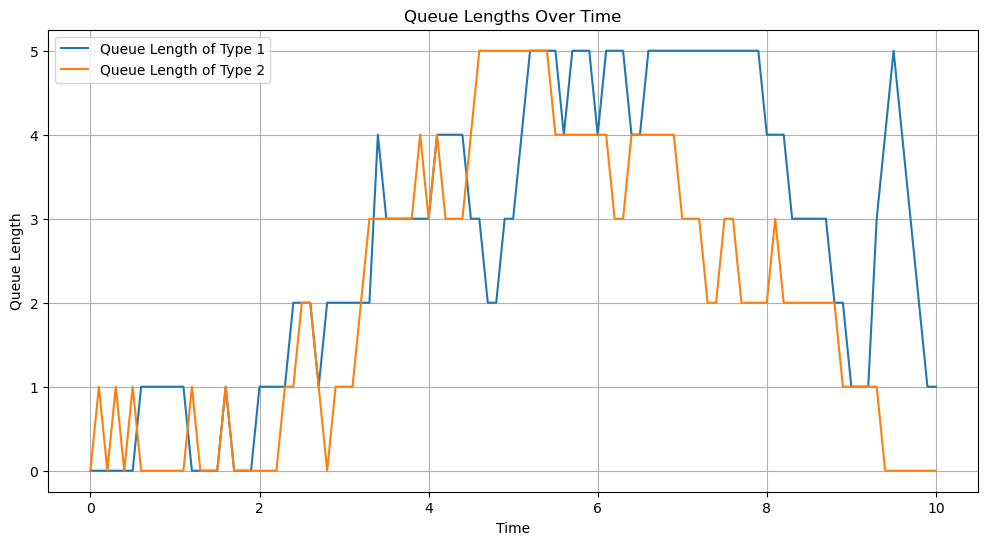

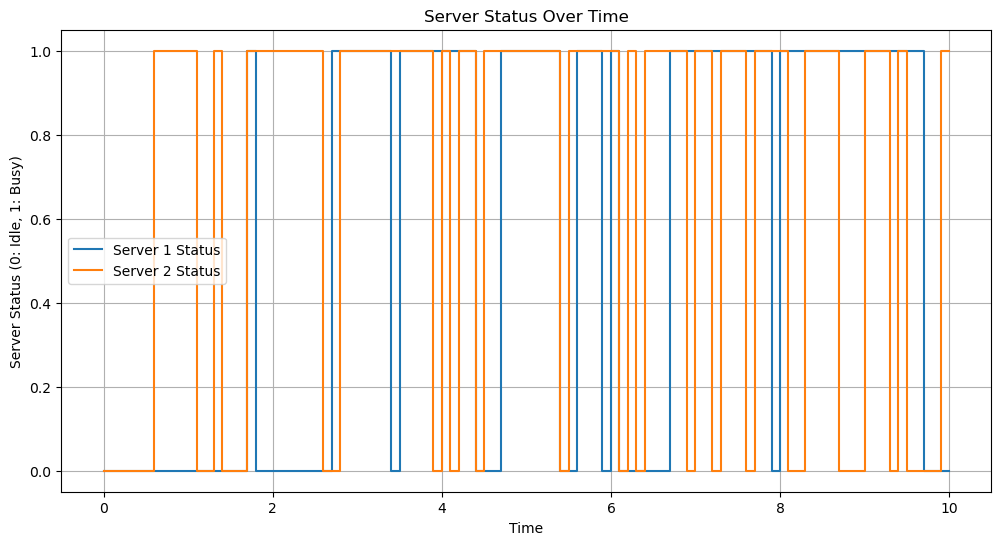

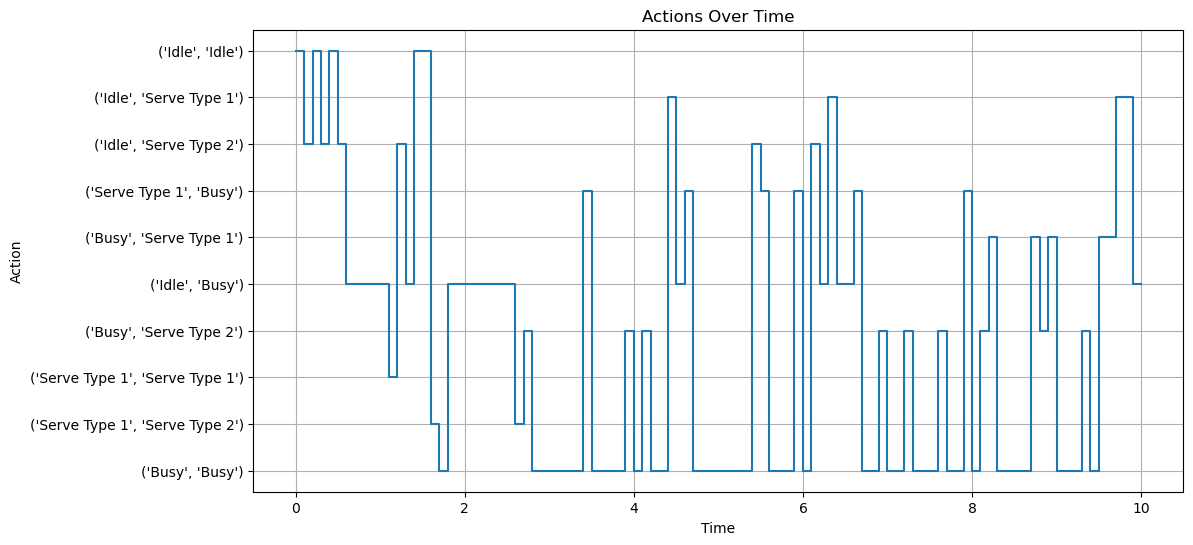

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random  # Import random library

# Set random seed to ensure reproducibility
np.random.seed(2024)
random.seed(2024)  # Set the random seed for the random library

# Define parameters
T = 10          # Time range
M = 5           # Maximum number of calls in the system
lambda1 = 2     # Arrival rate for type 1 customers
lambda2 = 2     # Arrival rate for type 2 customers
mu1 = 1         # Service rate for server 1
mu2 = 2         # Service rate for server 2
dt = 0.1        # Time step
gamma = 0.95    # Discount factor
alpha = 0.1     # Learning rate for Q-learning
epsilon = 0.1   # Exploration rate for ε-greedy strategy
episodes = 1000 # Number of training episodes

# Define state and action spaces
state_space = []
for q1 in range(M + 1):
    for q2 in range(M + 1):
        for b1 in [0, 1]:
            for b2 in [0, 1]:
                state_space.append((q1, q2, b1, b2))

# Define action space function, returning available actions based on the current state
def get_available_actions(state):
    q1, q2, b1, b2 = state
    actions = []
    # Actions are (a1, a2), representing actions for server 1 and server 2

    # Possible actions for server 1
    if b1 == 0:
        if q1 > 0:
            actions_server1 = ['Serve Type 1', 'Idle']
        else:
            actions_server1 = ['Idle']
    else:
        actions_server1 = ['Busy']  # Action is 'Busy' when the server is busy

    # Possible actions for server 2
    if b2 == 0:
        actions_server2 = []
        if q1 > 0:
            actions_server2.append('Serve Type 1')
        if q2 > 0:
            actions_server2.append('Serve Type 2')
        if not actions_server2:
            actions_server2.append('Idle')
    else:
        actions_server2 = ['Busy']

    # Combine actions for server 1 and server 2
    actions = []
    for a1 in actions_server1:
        for a2 in actions_server2:
            actions.append((a1, a2))
    return actions

# Initialize Q-table
Q = {}
for state in state_space:
    Q[state] = {}
    available_actions = get_available_actions(state)
    for action in available_actions:
        Q[state][action] = 0.0

# Reward function
def get_reward(state, action):
    q1, q2, b1, b2 = state
    wait_penalty = q1 + q2  # Penalty for the number of waiting customers
    invalid_action_penalty = 0
    # Check validity of action
    if b1 == 0:
        if action[0] == 'Serve Type 1' and q1 == 0:
            invalid_action_penalty += 10
    if b2 == 0:
        if action[1] == 'Serve Type 1' and q1 == 0:
            invalid_action_penalty += 10
        if action[1] == 'Serve Type 2' and q2 == 0:
            invalid_action_penalty += 10
    return - (wait_penalty + invalid_action_penalty)

# ε-greedy strategy to choose action
def choose_action(state):
    available_actions = list(Q[state].keys())
    if random.uniform(0, 1) < epsilon:
        return random.choice(available_actions)
    else:
        q_values = Q[state]
        max_value = max(q_values.values())
        max_actions = [a for a, v in q_values.items() if v == max_value]
        return random.choice(max_actions)

# Simulate environment events: customer arrivals and service completions
def simulate_environment(state, action):
    q1, q2, b1, b2 = state
    # Update server status
    if b1 == 0:
        if action[0] == 'Serve Type 1' and q1 > 0:
            b1 = 1  # Server 1 becomes busy
            q1 = max(q1 - 1, 0)
    if b2 == 0:
        if action[1] == 'Serve Type 1' and q1 > 0:
            b2 = 1
            q1 = max(q1 - 1, 0)
        elif action[1] == 'Serve Type 2' and q2 > 0:
            b2 = 1
            q2 = max(q2 - 1, 0)
    # Customer arrivals
    arrivals_type1 = np.random.poisson(lambda1 * dt)
    arrivals_type2 = np.random.poisson(lambda2 * dt)
    q1 = min(q1 + arrivals_type1, M)
    q2 = min(q2 + arrivals_type2, M)
    # Service completions
    if b1 == 1 and random.uniform(0, 1) < mu1 * dt:
        b1 = 0  # Server 1 becomes idle after completing service
    if b2 == 1 and random.uniform(0, 1) < mu2 * dt:
        b2 = 0  # Server 2 becomes idle after completing service
    next_state = (q1, q2, b1, b2)
    return next_state

# Q-learning training process
for episode in range(episodes):
    # Initialize state
    q1 = 0
    q2 = 0
    b1 = 0
    b2 = 0
    state = (q1, q2, b1, b2)
    t = 0
    while t < int(T / dt):
        # Choose action
        if state in Q and Q[state]:
            action = choose_action(state)
        else:
            action = ('Idle', 'Idle')
        # Get reward
        reward = get_reward(state, action)
        # Simulate environment, get next state
        next_state = simulate_environment(state, action)
        # Update Q-value
        if next_state in Q and Q[next_state]:
            max_next_q = max(Q[next_state].values())
        else:
            max_next_q = 0.0
        Q[state][action] += alpha * (reward + gamma * max_next_q - Q[state][action])
        state = next_state
        t += 1

# Function to simulate the system using the learned policy
def simulate_system(T, dt):
    time_steps = int(T / dt)
    q1 = 0
    q2 = 0
    b1 = 0
    b2 = 0
    state = (q1, q2, b1, b2)
    t = 0
    action_log = []

    # Data for visualization
    times = []
    q1_list = []
    q2_list = []
    b1_list = []
    b2_list = []
    actions_taken = []

    while t <= time_steps:
        current_time = t * dt

        # Choose action
        if state in Q and Q[state]:
            action = max(Q[state], key=Q[state].get)
        else:
            action = ('Idle', 'Idle')

        # Log actions
        action_log.append((current_time, q1, q2, b1, b2, action))

        # Simulate environment, get next state
        next_state = simulate_environment(state, action)

        # Record data for visualization
        times.append(current_time)
        q1_list.append(q1)
        q2_list.append(q2)
        b1_list.append(b1)
        b2_list.append(b2)
        actions_taken.append(action)

        state = next_state
        q1, q2, b1, b2 = state
        t += 1

    # Output action log
    print("Time\tq1\tq2\tb1\tb2\tAction")
    for log in action_log:
        time, q1_log, q2_log, b1_log, b2_log, action = log
        print(f"{time:.1f}\t{q1_log}\t{q2_log}\t{b1_log}\t{b2_log}\t{action}")

    # Visualize queue length changes over time
    plt.figure(figsize=(12,6))
    plt.plot(times, q1_list, label='Queue Length of Type 1')
    plt.plot(times, q2_list, label='Queue Length of Type 2')
    plt.xlabel('Time')
    plt.ylabel('Queue Length')
    plt.title('Queue Lengths Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualize server status changes over time
    plt.figure(figsize=(12,6))
    plt.step(times, b1_list, where='post', label='Server 1 Status')
    plt.step(times, b2_list, where='post', label='Server 2 Status')
    plt.xlabel('Time')
    plt.ylabel('Server Status (0: Idle, 1: Busy)')
    plt.title('Server Status Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Map actions to numbers for plotting
    unique_actions = list(set(actions_taken))
    action_to_number = {action: i for i, action in enumerate(unique_actions)}
    action_numbers = [action_to_number[a] for a in actions_taken]

    # Visualize actions changes over time
    plt.figure(figsize=(12,6))
    plt.step(times, action_numbers, where='post')
    plt.xlabel('Time')
    plt.ylabel('Action')
    plt.title('Actions Over Time')
    plt.yticks(list(action_to_number.values()), [str(a) for a in action_to_number.keys()])
    plt.grid(True)
    plt.show()

# Run the simulation
simulate_system(T, dt)


Running simulation with parameters: {'lambda1': 2, 'lambda2': 2, 'mu1': 1, 'mu2': 2}
Running simulation with parameters: {'lambda1': 3, 'lambda2': 2, 'mu1': 1, 'mu2': 2}
Running simulation with parameters: {'lambda1': 2, 'lambda2': 3, 'mu1': 1, 'mu2': 2}
Running simulation with parameters: {'lambda1': 2, 'lambda2': 2, 'mu1': 1.5, 'mu2': 2}
Running simulation with parameters: {'lambda1': 2, 'lambda2': 2, 'mu1': 1, 'mu2': 1.5}
Running simulation with parameters: {'lambda1': 2.5, 'lambda2': 2.5, 'mu1': 1, 'mu2': 1}


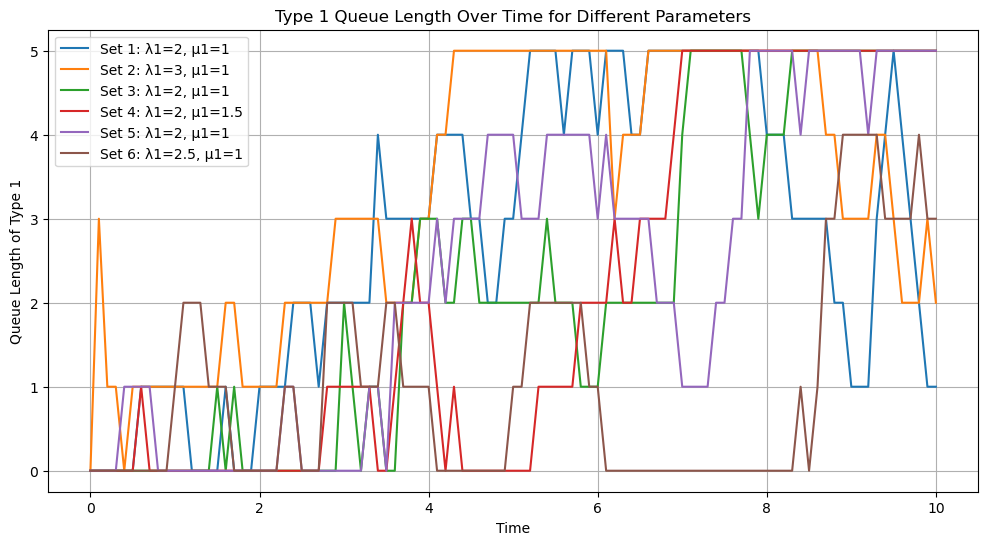

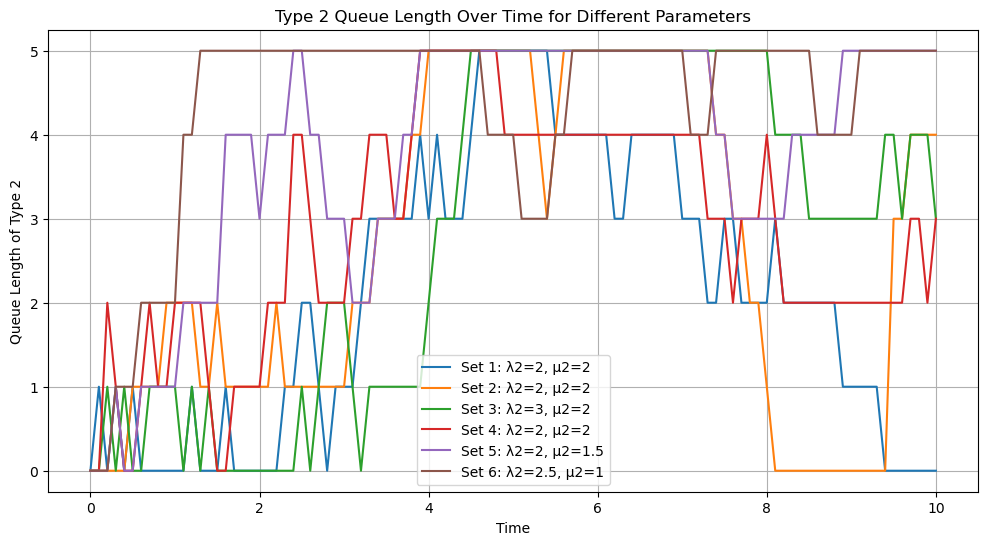

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to run Q-learning with given parameters
def q_learning_simulation(T, M, lambda1, lambda2, mu1, mu2, dt, gamma, alpha, epsilon, episodes):
    # Define state and action spaces
    state_space = []
    for q1 in range(M + 1):
        for q2 in range(M + 1):
            for b1 in [0, 1]:
                for b2 in [0, 1]:
                    state_space.append((q1, q2, b1, b2))

    # Define action space function, returning available actions based on the current state
    def get_available_actions(state):
        q1, q2, b1, b2 = state
        # Actions are (a1, a2), representing actions for server 1 and server 2

        # Possible actions for server 1
        if b1 == 0:
            if q1 > 0:
                actions_server1 = ['Serve Type 1', 'Idle']
            else:
                actions_server1 = ['Idle']
        else:
            actions_server1 = ['Busy']  # Action is 'Busy' when the server is busy

        # Possible actions for server 2
        if b2 == 0:
            actions_server2 = []
            if q1 > 0:
                actions_server2.append('Serve Type 1')
            if q2 > 0:
                actions_server2.append('Serve Type 2')
            if not actions_server2:
                actions_server2.append('Idle')
        else:
            actions_server2 = ['Busy']

        # Combine actions for server 1 and server 2
        actions = []
        for a1 in actions_server1:
            for a2 in actions_server2:
                actions.append((a1, a2))
        return actions

    # Initialize Q-table
    Q = {}
    for state in state_space:
        Q[state] = {}
        available_actions = get_available_actions(state)
        for action in available_actions:
            Q[state][action] = 0.0

    # Reward function
    def get_reward(state, action):
        q1, q2, b1, b2 = state
        wait_penalty = q1 + q2  # Penalty for the number of waiting customers
        invalid_action_penalty = 0
        # Check validity of action
        if b1 == 0:
            if action[0] == 'Serve Type 1' and q1 == 0:
                invalid_action_penalty += 10
        if b2 == 0:
            if action[1] == 'Serve Type 1' and q1 == 0:
                invalid_action_penalty += 10
            if action[1] == 'Serve Type 2' and q2 == 0:
                invalid_action_penalty += 10
        return - (wait_penalty + invalid_action_penalty)

    # ε-greedy strategy to choose action
    def choose_action(state):
        available_actions = list(Q[state].keys())
        if random.uniform(0, 1) < epsilon:
            return random.choice(available_actions)
        else:
            q_values = Q[state]
            max_value = max(q_values.values())
            max_actions = [a for a, v in q_values.items() if v == max_value]
            return random.choice(max_actions)

    # Simulate environment events: customer arrivals and service completions
    def simulate_environment(state, action):
        q1, q2, b1, b2 = state
        # Update server status
        if b1 == 0:
            if action[0] == 'Serve Type 1' and q1 > 0:
                b1 = 1  # Server 1 becomes busy
                q1 = max(q1 - 1, 0)
        if b2 == 0:
            if action[1] == 'Serve Type 1' and q1 > 0:
                b2 = 1
                q1 = max(q1 - 1, 0)
            elif action[1] == 'Serve Type 2' and q2 > 0:
                b2 = 1
                q2 = max(q2 - 1, 0)
        # Customer arrivals
        arrivals_type1 = np.random.poisson(lambda1 * dt)
        arrivals_type2 = np.random.poisson(lambda2 * dt)
        q1 = min(q1 + arrivals_type1, M)
        q2 = min(q2 + arrivals_type2, M)
        # Service completions
        if b1 == 1 and random.uniform(0, 1) < mu1 * dt:
            b1 = 0  # Server 1 becomes idle after completing service
        if b2 == 1 and random.uniform(0, 1) < mu2 * dt:
            b2 = 0  # Server 2 becomes idle after completing service
        next_state = (q1, q2, b1, b2)
        return next_state

    # Q-learning training process
    for episode in range(episodes):
        # Initialize state
        q1 = 0
        q2 = 0
        b1 = 0
        b2 = 0
        state = (q1, q2, b1, b2)
        t = 0
        while t < int(T / dt):
            # Choose action
            if state in Q and Q[state]:
                action = choose_action(state)
            else:
                action = ('Idle', 'Idle')
            # Get reward
            reward = get_reward(state, action)
            # Simulate environment, get next state
            next_state = simulate_environment(state, action)
            # Update Q-value
            if next_state in Q and Q[next_state]:
                max_next_q = max(Q[next_state].values())
            else:
                max_next_q = 0.0
            Q[state][action] += alpha * (reward + gamma * max_next_q - Q[state][action])
            state = next_state
            t += 1

    return Q  # Return the learned Q-table

# Function to simulate the system using the learned policy
def simulate_system(Q, T, dt, lambda1, lambda2, mu1, mu2, M):
    time_steps = int(T / dt)
    q1 = 0
    q2 = 0
    b1 = 0
    b2 = 0
    state = (q1, q2, b1, b2)
    t = 0
    action_log = []

    # Data for visualization
    times = []
    q1_list = []
    q2_list = []
    b1_list = []
    b2_list = []
    actions_taken = []

    # Define internal simulate_environment to capture lambda and mu
    def simulate_environment(state, action):
        q1, q2, b1, b2 = state
        # Update server status
        if b1 == 0:
            if action[0] == 'Serve Type 1' and q1 > 0:
                b1 = 1  # Server 1 becomes busy
                q1 = max(q1 - 1, 0)
        if b2 == 0:
            if action[1] == 'Serve Type 1' and q1 > 0:
                b2 = 1
                q1 = max(q1 - 1, 0)
            elif action[1] == 'Serve Type 2' and q2 > 0:
                b2 = 1
                q2 = max(q2 - 1, 0)
        # Customer arrivals
        arrivals_type1 = np.random.poisson(lambda1 * dt)
        arrivals_type2 = np.random.poisson(lambda2 * dt)
        q1 = min(q1 + arrivals_type1, M)
        q2 = min(q2 + arrivals_type2, M)
        # Service completions
        if b1 == 1 and random.uniform(0, 1) < mu1 * dt:
            b1 = 0  # Server 1 becomes idle after completing service
        if b2 == 1 and random.uniform(0, 1) < mu2 * dt:
            b2 = 0  # Server 2 becomes idle after completing service
        next_state = (q1, q2, b1, b2)
        return next_state

    while t <= time_steps:
        current_time = t * dt

        # Choose action
        if state in Q and Q[state]:
            action = max(Q[state], key=Q[state].get)
        else:
            action = ('Idle', 'Idle')

        # Log actions
        action_log.append((current_time, q1, q2, b1, b2, action))

        # Simulate environment, get next state
        next_state = simulate_environment(state, action)

        # Record data for visualization
        times.append(current_time)
        q1_list.append(q1)
        q2_list.append(q2)
        b1_list.append(b1)
        b2_list.append(b2)
        actions_taken.append(action)

        state = next_state
        q1, q2, b1, b2 = state
        t += 1

    return times, q1_list, q2_list, b1_list, b2_list, actions_taken, action_log

# Define different parameter sets to observe how results change
parameter_sets = [
    {'lambda1': 2, 'lambda2': 2, 'mu1': 1, 'mu2': 2},    # Original parameters
    {'lambda1': 3, 'lambda2': 2, 'mu1': 1, 'mu2': 2},    # Increase arrival rate of type 1 customers
    {'lambda1': 2, 'lambda2': 3, 'mu1': 1, 'mu2': 2},    # Increase arrival rate of type 2 customers
    {'lambda1': 2, 'lambda2': 2, 'mu1': 1.5, 'mu2': 2},  # Increase service rate of server 1
    {'lambda1': 2, 'lambda2': 2, 'mu1': 1, 'mu2': 1.5},  # Decrease service rate of server 2
    {'lambda1': 2.5, 'lambda2': 2.5, 'mu1': 1, 'mu2': 1} # Increase arrival rates, decrease service rates
]

# Other parameters
T = 10
M = 5
dt = 0.1
gamma = 0.95
alpha = 0.1
epsilon = 0.1
episodes = 1000

# Set random seed to ensure reproducibility
np.random.seed(2024)
random.seed(2024)

# Run simulations for each parameter set and collect results
results = []
for params in parameter_sets:
    print(f"Running simulation with parameters: {params}")
    # Run Q-learning
    Q = q_learning_simulation(T, M, params['lambda1'], params['lambda2'], params['mu1'], params['mu2'], dt, gamma, alpha, epsilon, episodes)
    # Simulate system using the learned policy
    times, q1_list, q2_list, b1_list, b2_list, actions_taken, action_log = simulate_system(Q, T, dt, params['lambda1'], params['lambda2'], params['mu1'], params['mu2'], M)
    results.append({
        'params': params,
        'times': times,
        'q1_list': q1_list,
        'q2_list': q2_list,
        'b1_list': b1_list,
        'b2_list': b2_list,
        'actions_taken': actions_taken,
        'action_log': action_log
    })

# Now, plot results for comparison
# For example, compare queue length changes over time under different parameters

# Plot Type 1 queue length over time for different parameter sets
plt.figure(figsize=(12,6))
for i, result in enumerate(results):
    times = result['times']
    q1_list = result['q1_list']
    plt.plot(times, q1_list, label=f"Set {i+1}: λ1={result['params']['lambda1']}, μ1={result['params']['mu1']}")

plt.xlabel('Time')
plt.ylabel('Queue Length of Type 1')
plt.title('Type 1 Queue Length Over Time for Different Parameters')
plt.legend()
plt.grid(True)
plt.show()

# Plot Type 2 queue length over time for different parameter sets
plt.figure(figsize=(12,6))
for i, result in enumerate(results):
    times = result['times']
    q2_list = result['q2_list']
    plt.plot(times, q2_list, label=f"Set {i+1}: λ2={result['params']['lambda2']}, μ2={result['params']['mu2']}")

plt.xlabel('Time')
plt.ylabel('Queue Length of Type 2')
plt.title('Type 2 Queue Length Over Time for Different Parameters')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to run Q-learning with given parameters
def q_learning_simulation(T, M, lambda1, lambda2, mu1, mu2, dt, gamma, alpha, epsilon, episodes):
    # Define state and action spaces
    state_space = []
    for q1 in range(M + 1):
        for q2 in range(M + 1):
            for b1 in [0, 1]:
                for b2 in [0, 1]:
                    state_space.append((q1, q2, b1, b2))

    # Define action space function
    def get_available_actions(state):
        q1, q2, b1, b2 = state

        # Possible actions for server 1
        if b1 == 0:
            if q1 > 0:
                actions_server1 = ['Serve Type 1', 'Idle']
            else:
                actions_server1 = ['Idle']
        else:
            actions_server1 = ['Busy']

        # Possible actions for server 2
        if b2 == 0:
            actions_server2 = []
            if q1 > 0:
                actions_server2.append('Serve Type 1')
            if q2 > 0:
                actions_server2.append('Serve Type 2')
            if not actions_server2:
                actions_server2.append('Idle')
        else:
            actions_server2 = ['Busy']

        # Combine actions
        actions = []
        for a1 in actions_server1:
            for a2 in actions_server2:
                actions.append((a1, a2))
        return actions

    # Initialize Q-table
    Q = {}
    for state in state_space:
        Q[state] = {}
        available_actions = get_available_actions(state)
        for action in available_actions:
            Q[state][action] = 0.0

    # Reward function
    def get_reward(state, action):
        q1, q2, b1, b2 = state
        wait_penalty = q1 + q2  # Penalty for waiting customers
        invalid_action_penalty = 0
        # Check validity of action
        if b1 == 0:
            if action[0] == 'Serve Type 1' and q1 == 0:
                invalid_action_penalty += 10
        if b2 == 0:
            if action[1] == 'Serve Type 1' and q1 == 0:
                invalid_action_penalty += 10
            if action[1] == 'Serve Type 2' and q2 == 0:
                invalid_action_penalty += 10
        return - (wait_penalty + invalid_action_penalty)

    # ε-greedy strategy to choose action
    def choose_action(state):
        available_actions = list(Q[state].keys())
        if random.uniform(0, 1) < epsilon:
            return random.choice(available_actions)
        else:
            q_values = Q[state]
            max_value = max(q_values.values())
            max_actions = [a for a, v in q_values.items() if v == max_value]
            return random.choice(max_actions)

    # Simulate environment events
    def simulate_environment(state, action):
        q1, q2, b1, b2 = state
        # Update server status
        if b1 == 0:
            if action[0] == 'Serve Type 1' and q1 > 0:
                b1 = 1
                q1 = max(q1 - 1, 0)
        if b2 == 0:
            if action[1] == 'Serve Type 1' and q1 > 0:
                b2 = 1
                q1 = max(q1 - 1, 0)
            elif action[1] == 'Serve Type 2' and q2 > 0:
                b2 = 1
                q2 = max(q2 - 1, 0)
        # Customer arrivals
        arrivals_type1 = np.random.poisson(lambda1 * dt)
        arrivals_type2 = np.random.poisson(lambda2 * dt)
        q1 = min(q1 + arrivals_type1, M)
        q2 = min(q2 + arrivals_type2, M)
        # Service completions
        if b1 == 1 and random.uniform(0, 1) < mu1 * dt:
            b1 = 0
        if b2 == 1 and random.uniform(0, 1) < mu2 * dt:
            b2 = 0
        next_state = (q1, q2, b1, b2)
        return next_state

    # Q-learning training process
    for episode in range(episodes):
        q1 = 0
        q2 = 0
        b1 = 0
        b2 = 0
        state = (q1, q2, b1, b2)
        t = 0
        while t < int(T / dt):
            if state in Q and Q[state]:
                action = choose_action(state)
            else:
                action = ('Idle', 'Idle')
            reward = get_reward(state, action)
            next_state = simulate_environment(state, action)
            if next_state in Q and Q[next_state]:
                max_next_q = max(Q[next_state].values())
            else:
                max_next_q = 0.0
            Q[state][action] += alpha * (reward + gamma * max_next_q - Q[state][action])
            state = next_state
            t += 1

    return Q  # Return the learned Q-table

# Function to simulate the system using the learned policy
def simulate_system(Q, T, dt, lambda1, lambda2, mu1, mu2, M):
    time_steps = int(T / dt)
    q1 = 0
    q2 = 0
    b1 = 0
    b2 = 0
    state = (q1, q2, b1, b2)
    t = 0
    action_log = []

    # Data for metrics
    times = []
    q1_list = []
    q2_list = []
    b1_list = []
    b2_list = []
    actions_taken = []
    rewards = []
    waiting_times_q1 = []
    waiting_times_q2 = []
    customers_served_q1 = 0
    customers_served_q2 = 0

    # Initialize waiting time trackers
    queue1_wait_times = [0]*M
    queue2_wait_times = [0]*M

    # Define internal simulate_environment
    def simulate_environment(state, action):
        nonlocal customers_served_q1, customers_served_q2
        q1, q2, b1, b2 = state
        # Update server status
        if b1 == 0:
            if action[0] == 'Serve Type 1' and q1 > 0:
                b1 = 1
                q1 = max(q1 - 1, 0)
                customers_served_q1 += 1
                waiting_times_q1.append(queue1_wait_times.pop(0))
        if b2 == 0:
            if action[1] == 'Serve Type 1' and q1 > 0:
                b2 = 1
                q1 = max(q1 - 1, 0)
                customers_served_q1 += 1
                waiting_times_q1.append(queue1_wait_times.pop(0))
            elif action[1] == 'Serve Type 2' and q2 > 0:
                b2 = 1
                q2 = max(q2 - 1, 0)
                customers_served_q2 += 1
                waiting_times_q2.append(queue2_wait_times.pop(0))
        # Customer arrivals
        arrivals_type1 = np.random.poisson(lambda1 * dt)
        arrivals_type2 = np.random.poisson(lambda2 * dt)
        q1_arrivals = min(arrivals_type1, M - q1)
        q2_arrivals = min(arrivals_type2, M - q2)
        q1 += q1_arrivals
        q2 += q2_arrivals
        # Update waiting time trackers
        queue1_wait_times.extend([0]*q1_arrivals)
        queue2_wait_times.extend([0]*q2_arrivals)
        # Service completions
        if b1 == 1 and random.uniform(0, 1) < mu1 * dt:
            b1 = 0
        if b2 == 1 and random.uniform(0, 1) < mu2 * dt:
            b2 = 0
        next_state = (q1, q2, b1, b2)
        return next_state

    while t <= time_steps:
        current_time = t * dt

        # Choose action
        if state in Q and Q[state]:
            action = max(Q[state], key=Q[state].get)
        else:
            action = ('Idle', 'Idle')

        # Log actions
        action_log.append((current_time, state[0], state[1], state[2], state[3], action))

        # Get reward
        reward = - (state[0] + state[1])
        rewards.append(reward)

        # Simulate environment, get next state
        next_state = simulate_environment(state, action)

        # Record data for metrics
        times.append(current_time)
        q1_list.append(state[0])
        q2_list.append(state[1])
        b1_list.append(state[2])
        b2_list.append(state[3])
        actions_taken.append(action)

        # Update waiting times for customers in queues
        queue1_wait_times = [wt + dt for wt in queue1_wait_times]
        queue2_wait_times = [wt + dt for wt in queue2_wait_times]

        state = next_state
        t += 1

    # Calculate metrics
    average_queue_length_q1 = np.mean(q1_list)
    average_queue_length_q2 = np.mean(q2_list)
    average_waiting_time_q1 = np.mean(waiting_times_q1) if waiting_times_q1 else 0
    average_waiting_time_q2 = np.mean(waiting_times_q2) if waiting_times_q2 else 0
    server_utilization_b1 = np.mean(b1_list)
    server_utilization_b2 = np.mean(b2_list)
    total_reward = sum(rewards)

    metrics = {
        'average_queue_length_q1': average_queue_length_q1,
        'average_queue_length_q2': average_queue_length_q2,
        'average_waiting_time_q1': average_waiting_time_q1,
        'average_waiting_time_q2': average_waiting_time_q2,
        'server_utilization_b1': server_utilization_b1,
        'server_utilization_b2': server_utilization_b2,
        'customers_served_q1': customers_served_q1,
        'customers_served_q2': customers_served_q2,
        'total_reward': total_reward
    }

    return metrics

# Define different parameter sets
parameter_sets = [
    {'lambda1': 2, 'lambda2': 2, 'mu1': 1, 'mu2': 2},    # Original parameters
    {'lambda1': 3, 'lambda2': 2, 'mu1': 1, 'mu2': 2},    # Increase arrival rate of type 1 customers
    {'lambda1': 2, 'lambda2': 3, 'mu1': 1, 'mu2': 2},    # Increase arrival rate of type 2 customers
    {'lambda1': 2, 'lambda2': 2, 'mu1': 1.5, 'mu2': 2},  # Increase service rate of server 1
    {'lambda1': 2, 'lambda2': 2, 'mu1': 1, 'mu2': 1.5},  # Decrease service rate of server 2
    {'lambda1': 2.5, 'lambda2': 2.5, 'mu1': 1.5, 'mu2': 1.5}, # Increase arrival rates, decrease service rates
    {'lambda1': 2, 'lambda2': 2, 'mu1': 2, 'mu2': 2},         # High service rate for server 1
    {'lambda1': 3, 'lambda2': 3, 'mu1': 1.5, 'mu2': 2},     # Mixed changes in service rates
    {'lambda1': 2, 'lambda2': 3.5, 'mu1': 1, 'mu2': 2},
    {'lambda1': 2.5, 'lambda2': 2.5, 'mu1': 2, 'mu2': 2}     # High arrival and service rates
]

# Other parameters
T = 10
M = 5
dt = 0.1
gamma = 0.95
alpha = 0.1
epsilon = 0.1
episodes = 1000

# Set random seed to ensure reproducibility
np.random.seed(2024)
random.seed(2024)

# Run simulations for each parameter set and collect results
metrics_list = []
for idx, params in enumerate(parameter_sets):
    print(f"Running simulation {idx+1} with parameters: {params}")
    # Run Q-learning
    Q = q_learning_simulation(T, M, params['lambda1'], params['lambda2'], params['mu1'], params['mu2'], dt, gamma, alpha, epsilon, episodes)
    # Simulate system using the learned policy
    metrics = simulate_system(Q, T, dt, params['lambda1'], params['lambda2'], params['mu1'], params['mu2'], M)
    metrics['params'] = params
    metrics_list.append(metrics)

# Display metrics for each parameter set
for idx, metrics in enumerate(metrics_list):
    print(f"\nMetrics for Simulation {idx+1}:")
    print(f"Parameters: {metrics['params']}")
    print(f"Average Queue Length (Type 1): {metrics['average_queue_length_q1']:.2f}")
    print(f"Average Queue Length (Type 2): {metrics['average_queue_length_q2']:.2f}")
    print(f"Average Waiting Time (Type 1): {metrics['average_waiting_time_q1']:.2f}")
    print(f"Average Waiting Time (Type 2): {metrics['average_waiting_time_q2']:.2f}")
    print(f"Server Utilization (Server 1): {metrics['server_utilization_b1']*100:.2f}%")
    print(f"Server Utilization (Server 2): {metrics['server_utilization_b2']*100:.2f}%")
    print(f"Customers Served (Type 1): {metrics['customers_served_q1']}")
    print(f"Customers Served (Type 2): {metrics['customers_served_q2']}")
    print(f"Total Reward: {metrics['total_reward']:.2f}")


Running simulation 1 with parameters: {'lambda1': 2, 'lambda2': 2, 'mu1': 1, 'mu2': 2}
Running simulation 2 with parameters: {'lambda1': 3, 'lambda2': 2, 'mu1': 1, 'mu2': 2}
Running simulation 3 with parameters: {'lambda1': 2, 'lambda2': 3, 'mu1': 1, 'mu2': 2}
Running simulation 4 with parameters: {'lambda1': 2, 'lambda2': 2, 'mu1': 1.5, 'mu2': 2}
Running simulation 5 with parameters: {'lambda1': 2, 'lambda2': 2, 'mu1': 1, 'mu2': 1.5}
Running simulation 6 with parameters: {'lambda1': 2.5, 'lambda2': 2.5, 'mu1': 1.5, 'mu2': 1.5}
Running simulation 7 with parameters: {'lambda1': 2, 'lambda2': 2, 'mu1': 2, 'mu2': 2}
Running simulation 8 with parameters: {'lambda1': 3, 'lambda2': 3, 'mu1': 1.5, 'mu2': 2}
Running simulation 9 with parameters: {'lambda1': 2, 'lambda2': 3.5, 'mu1': 1, 'mu2': 2}
Running simulation 10 with parameters: {'lambda1': 2.5, 'lambda2': 2.5, 'mu1': 2, 'mu2': 2}

Metrics for Simulation 1:
Parameters: {'lambda1': 2, 'lambda2': 2, 'mu1': 1, 'mu2': 2}
Average Queue Length 

时间	q1	q2	b1	b2	动作
0.0	0	0	0	0	('Idle', 'Idle')
0.1	0	0	0	0	('Idle', 'Idle')
0.2	0	0	0	0	('Idle', 'Idle')
0.3	0	0	0	0	('Idle', 'Idle')
0.4	0	0	0	0	('Idle', 'Idle')
0.5	0	0	0	0	('Idle', 'Idle')
0.6	0	0	0	0	('Idle', 'Idle')
0.7	0	0	0	0	('Idle', 'Idle')
0.8	0	0	0	0	('Idle', 'Idle')
0.9	1	0	0	0	('Serve Type 1', 'Serve Type 1')
1.0	0	1	1	0	('Busy', 'Serve Type 2')
1.1	0	1	1	0	('Busy', 'Serve Type 2')
1.2	0	0	0	1	('Idle', 'Busy')
1.3	0	0	0	1	('Idle', 'Busy')
1.4	1	0	0	1	('Idle', 'Busy')
1.5	1	0	0	1	('Idle', 'Busy')
1.6	1	0	0	1	('Idle', 'Busy')
1.7	1	0	0	1	('Idle', 'Busy')
1.8	1	0	0	1	('Idle', 'Busy')
1.9	1	0	0	1	('Idle', 'Busy')
2.0	1	0	0	1	('Idle', 'Busy')
2.1	1	0	0	1	('Idle', 'Busy')
2.2	1	0	0	0	('Serve Type 1', 'Serve Type 1')
2.3	0	0	1	0	('Busy', 'Idle')
2.4	2	0	1	0	('Busy', 'Serve Type 1')
2.5	1	0	1	1	('Busy', 'Busy')
2.6	1	1	1	1	('Busy', 'Busy')
2.7	1	1	1	1	('Busy', 'Busy')
2.8	2	1	1	1	('Busy', 'Busy')
2.9	3	1	1	1	('Busy', 'Busy')
3.0	3	1	1	1	('Busy', 'Busy')
3.1	3	1	1	0	('Busy', 'Serve

/Users/mentha/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38431 (\N{CJK UNIFIED IDEOGRAPH-961F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mentha/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mentha/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mentha/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mentha/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing f

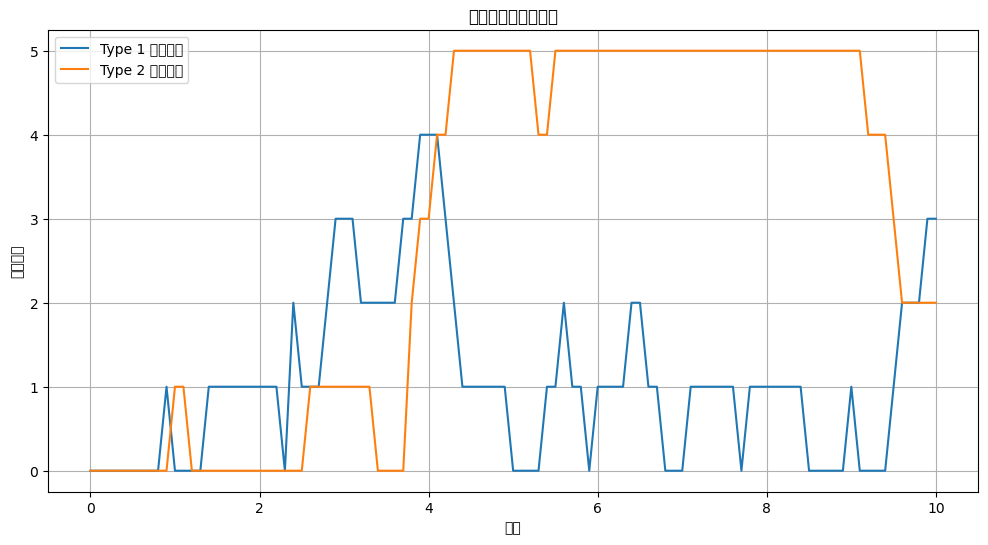

/Users/mentha/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26381 (\N{CJK UNIFIED IDEOGRAPH-670D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mentha/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21153 (\N{CJK UNIFIED IDEOGRAPH-52A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mentha/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22120 (\N{CJK UNIFIED IDEOGRAPH-5668}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mentha/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mentha/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing f

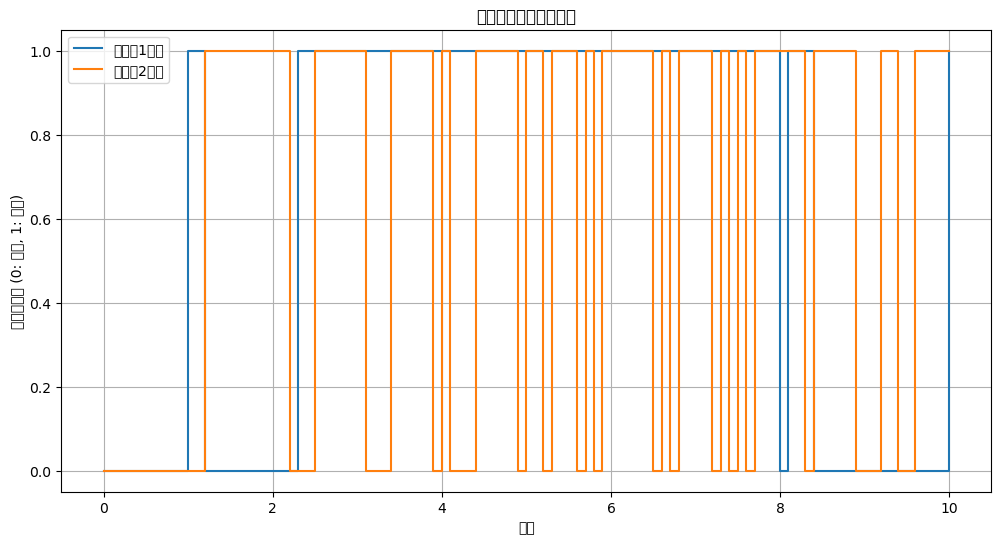

/Users/mentha/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/mentha/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


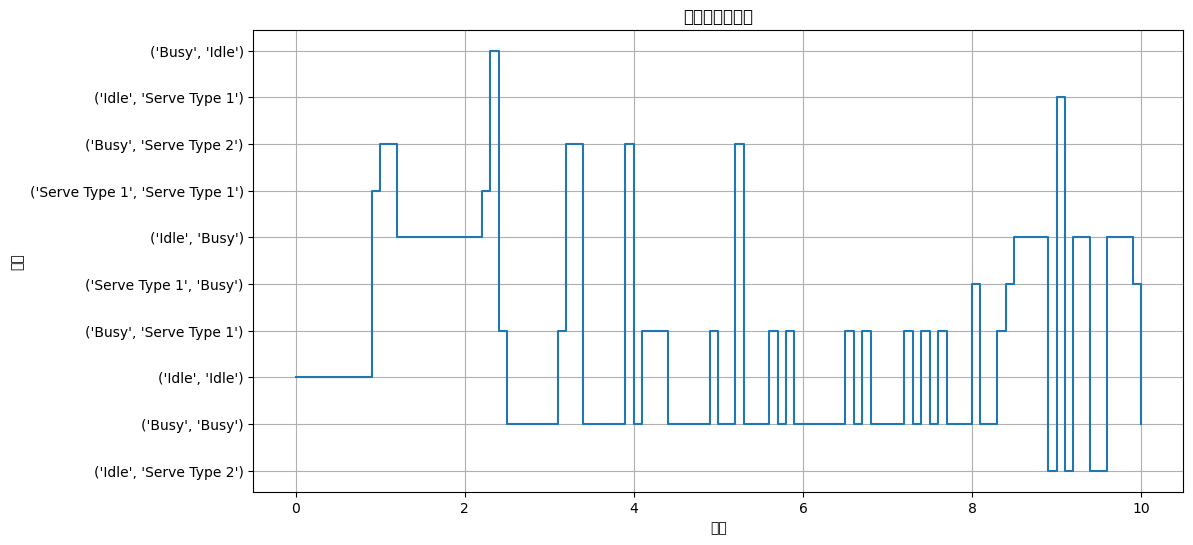

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random  # 引入 random 库

# 设置随机种子，确保结果可复现
np.random.seed(42)
random.seed(42)  # 设置 random 库的随机种子

# 定义参数
T = 10          # 时间范围
M = 5           # 系统中最大呼叫数量
lambda1 = 2     # 类型1客户的到达率
lambda2 = 2     # 类型2客户的到达率
mu1 = 1         # 服务器1的服务率
mu2 = 2         # 服务器2的服务率
dt = 0.1        # 时间步长
gamma = 0.95    # 折扣因子
alpha = 0.1     # Q-学习的学习率
epsilon = 0.1   # ε-贪心策略中的探索率
episodes = 1000 # 训练的回合数

# 定义状态和动作空间
state_space = []
for q1 in range(M + 1):
    for q2 in range(M + 1):
        for b1 in [0, 1]:
            for b2 in [0, 1]:
                state_space.append((q1, q2, b1, b2))

# 根据当前状态返回可用的动作列表的动作空间函数
def get_available_actions(state):
    q1, q2, b1, b2 = state
    actions = []
    # 动作为 (a1, a2)，表示服务器1和服务器2的动作

    # 服务器1的可能动作
    if b1 == 0:
        if q1 > 0:
            actions_server1 = ['Serve Type 1', 'Idle']
        else:
            actions_server1 = ['Idle']
    else:
        actions_server1 = ['Busy']  # 服务器忙碌时，动作为 'Busy'

    # 服务器2的可能动作
    if b2 == 0:
        actions_server2 = []
        if q1 > 0:
            actions_server2.append('Serve Type 1')
        if q2 > 0:
            actions_server2.append('Serve Type 2')
        if not actions_server2:
            actions_server2.append('Idle')
    else:
        actions_server2 = ['Busy']

    # 组合服务器1和服务器2的动作
    actions = []
    for a1 in actions_server1:
        for a2 in actions_server2:
            actions.append((a1, a2))
    return actions

# 初始化 Q 表
Q = {}
for state in state_space:
    Q[state] = {}
    available_actions = get_available_actions(state)
    for action in available_actions:
        Q[state][action] = 0.0

# 奖励函数
def get_reward(state, action):
    q1, q2, b1, b2 = state
    wait_penalty = q1 + q2  # 等待客户数量的惩罚
    invalid_action_penalty = 0
    # 检查动作的有效性
    if b1 == 0:
        if action[0] == 'Serve Type 1' and q1 == 0:
            invalid_action_penalty += 10
    if b2 == 0:
        if action[1] == 'Serve Type 1' and q1 == 0:
            invalid_action_penalty += 10
        if action[1] == 'Serve Type 2' and q2 == 0:
            invalid_action_penalty += 10
    return - (wait_penalty + invalid_action_penalty)

# ε-贪心策略选择动作
def choose_action(state):
    available_actions = list(Q[state].keys())
    if random.uniform(0, 1) < epsilon:
        return random.choice(available_actions)
    else:
        q_values = Q[state]
        max_value = max(q_values.values())
        max_actions = [a for a, v in q_values.items() if v == max_value]
        return random.choice(max_actions)

# 模拟环境中的事件：客户到达和服务完成
def simulate_environment(state, action):
    q1, q2, b1, b2 = state
    # 更新服务器状态
    if b1 == 0:
        if action[0] == 'Serve Type 1' and q1 > 0:
            b1 = 1  # 服务器1变为忙碌
            q1 = max(q1 - 1, 0)
    if b2 == 0:
        if action[1] == 'Serve Type 1' and q1 > 0:
            b2 = 1
            q1 = max(q1 - 1, 0)
        elif action[1] == 'Serve Type 2' and q2 > 0:
            b2 = 1
            q2 = max(q2 - 1, 0)
    # 客户到达
    arrivals_type1 = np.random.poisson(lambda1 * dt)
    arrivals_type2 = np.random.poisson(lambda2 * dt)
    q1 = min(q1 + arrivals_type1, M)
    q2 = min(q2 + arrivals_type2, M)
    # 服务完成
    if b1 == 1 and random.uniform(0, 1) < mu1 * dt:
        b1 = 0  # 服务完成，服务器1变为空闲
    if b2 == 1 and random.uniform(0, 1) < mu2 * dt:
        b2 = 0  # 服务完成，服务器2变为空闲
    next_state = (q1, q2, b1, b2)
    return next_state

# Q-学习训练过程
for episode in range(episodes):
    # 初始化状态
    q1 = 0
    q2 = 0
    b1 = 0
    b2 = 0
    state = (q1, q2, b1, b2)
    t = 0
    while t < int(T / dt):
        # 选择动作
        if state in Q and Q[state]:
            action = choose_action(state)
        else:
            action = ('Idle', 'Idle')
        # 获取奖励
        reward = get_reward(state, action)
        # 模拟环境，获取下一状态
        next_state = simulate_environment(state, action)
        # 更新 Q 值
        if next_state in Q and Q[next_state]:
            max_next_q = max(Q[next_state].values())
        else:
            max_next_q = 0.0
        Q[state][action] += alpha * (reward + gamma * max_next_q - Q[state][action])
        state = next_state
        t += 1

# 使用学习到的策略进行模拟
def simulate_system(T, dt):
    time_steps = int(T / dt)
    q1 = 0
    q2 = 0
    b1 = 0
    b2 = 0
    state = (q1, q2, b1, b2)
    t = 0
    action_log = []

    # 用于可视化的数据
    times = []
    q1_list = []
    q2_list = []
    b1_list = []
    b2_list = []
    actions_taken = []

    while t <= time_steps:
        current_time = t * dt

        # 选择动作
        if state in Q and Q[state]:
            action = max(Q[state], key=Q[state].get)
        else:
            action = ('Idle', 'Idle')

        # 记录动作日志
        action_log.append((current_time, q1, q2, b1, b2, action))

        # 模拟环境，获取下一状态
        next_state = simulate_environment(state, action)

        # 记录用于可视化的数据
        times.append(current_time)
        q1_list.append(q1)
        q2_list.append(q2)
        b1_list.append(b1)
        b2_list.append(b2)
        actions_taken.append(action)

        state = next_state
        q1, q2, b1, b2 = state
        t += 1

    # 输出动作日志
    print("时间\tq1\tq2\tb1\tb2\t动作")
    for log in action_log:
        time, q1_log, q2_log, b1_log, b2_log, action = log
        print(f"{time:.1f}\t{q1_log}\t{q2_log}\t{b1_log}\t{b2_log}\t{action}")

    # 可视化队列长度随时间的变化
    plt.figure(figsize=(12,6))
    plt.plot(times, q1_list, label='Type 1 队列长度')
    plt.plot(times, q2_list, label='Type 2 队列长度')
    plt.xlabel('时间')
    plt.ylabel('队列长度')
    plt.title('队列长度随时间变化')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 可视化服务器状态随时间的变化
    plt.figure(figsize=(12,6))
    plt.step(times, b1_list, where='post', label='服务器1状态')
    plt.step(times, b2_list, where='post', label='服务器2状态')
    plt.xlabel('时间')
    plt.ylabel('服务器状态 (0: 空闲, 1: 忙碌)')
    plt.title('服务器状态随时间变化')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 将动作映射为数字，以便绘图
    unique_actions = list(set(actions_taken))
    action_to_number = {action: i for i, action in enumerate(unique_actions)}
    action_numbers = [action_to_number[a] for a in actions_taken]

    # 可视化动作随时间的变化
    plt.figure(figsize=(12,6))
    plt.step(times, action_numbers, where='post')
    plt.xlabel('时间')
    plt.ylabel('动作')
    plt.title('动作随时间变化')
    plt.yticks(list(action_to_number.values()), [str(a) for a in action_to_number.keys()])
    plt.grid(True)
    plt.show()

# 运行模拟
simulate_system(T, dt)
